# Physics-Informed Neural Network for the Undamped Harmonic Oscillator using Fourier Features  
# Project 1: Scientific Machine Learning – IIT Mandi  

Atharva Joshi  
BSMS 2nd Year, IISER Bhopal  
Pre-Major: Physics, Mathematics, and Data Science  

**References:**  
- Lu et al. (2024), *Solving Oscillator ODEs via Soft-Constrained PINN with Minimal Data*, [arXiv:2408.11077](https://arxiv.org/abs/2408.11077)  
- DeepXDE Official Example Codes: [https://github.com/lululxvi/deepxde](https://github.com/lululxvi/deepxde)  

---

## Analytical Theory and Problem Formulation

We aim to solve the undamped harmonic oscillator equation using a Physics-Informed Neural Network (PINN) with Fourier feature encoding.

### Governing Equation

The target second-order ODE is:

$$
\frac{d^2 y}{dt^2} + \omega^2 y = 0
$$

Where:

- $y(t)$ is the displacement  
- $\omega$ is the angular frequency (here, $\omega = 2\pi$ for 1 second period)  

### Initial Condition (IC)

At $t=0$:

$$
y(0) = 1.0
$$

$$
\dot{y}(0) = 0.0
$$

### Boundary Condition (BC)

Since this is a time-only problem, no spatial boundary condition applies.

### Analytical Solution

The analytical solution is:

$$
y_{\text{true}}(t) = y_0 \cos(\omega t) + \frac{v_0}{\omega} \sin(\omega t)
$$

For this project with $y_0 = 1.0$ and $v_0 = 0.0$, this reduces to:

$$
y_{\text{true}}(t) = \cos(2\pi t)
$$

---

## PINN Implementation Strategy

### Input and Output Design

- **Input:** Time $t \in [0, 2]$  
- **Output:** Predicted displacement $y_{\theta}(t)$  

### Fourier Feature Encoding

Before feeding $t$ into the neural network, we transform it using Fourier features:

$$
\phi(t) = \left[ \sin(2\pi t), \cos(2\pi t) \right]
$$

This allows the network to better learn periodic behavior.

### Loss Function Formulation

The total loss $\mathcal{L}$ contains two terms:

1. **Physics-based ODE residual (PDE loss):**

$$
r(t) = \frac{d^2 y_{\theta}}{dt^2} + \omega^2 y_{\theta}(t)
$$

We minimize the mean squared error (MSE) of $r(t)$ over random collocation points.

2. **Initial Condition Loss:**

$$
\mathcal{L}_{\text{IC}} = \left( y_{\theta}(0) - y_0 \right)^2 + \left( \frac{d y_{\theta}}{dt}(0) - v_0 \right)^2
$$

3. **Total Loss:**

$$
\mathcal{L} = \text{MSE}(r(t)) + \mathcal{L}_{\text{IC}}
$$

### Collocation Point Sampling

- 200 random time points $t_{\text{coll}}$ uniformly sampled from $[0, 1]$

### Training Strategy

- Optimizer: Adam  
- Learning Rate: $1 \times 10^{-3}$ with step decay (factor $0.5$ every 500 epochs)  
- Epochs: 2000  
- Save model predictions at epochs 0 to 1000 in steps of 10 (for animation)  

### Model Architecture Summary

| Layer                  | Input Dimension | Output Dimension | Activation |
|------------------------|-----------------|------------------|------------|
| Fourier Feature Mapping | 1               | 2                | $\sin$, $\cos$ |
| Linear Layer 1         | 2               | 64               | Tanh        |
| Linear Layer 2         | 64              | 64               | Tanh        |
| Linear Layer 3         | 64              | 1                | Linear (no activation) |

**Total Trainable Parameters:** Approximately 8,129

---


In [9]:
# === Install Dependencies (Uncomment if not installed) ===
# If you get ModuleNotFoundError, run these:

# !pip install torch
# !pip install matplotlib
# !pip install numpy


/home/ashish/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Using device: cpu
Epoch    0 | Loss: ----
Epoch  100 | Loss: 0.09832968562841415
Epoch  200 | Loss: 0.002820304362103343
Epoch  300 | Loss: 0.0007010466069914401
Epoch  400 | Loss: 0.0004252249200362712
Epoch  500 | Loss: 0.00029377834289334714
Epoch  600 | Loss: 0.0002442339318804443
Epoch  700 | Loss: 0.00020191248040646315
Epoch  800 | Loss: 0.00016601667448412627
Epoch  900 | Loss: 0.000136057598865591
Epoch 1000 | Loss: 0.00011128134065074846
Epoch 1100 | Loss: 0.00010041164205176756
Epoch 1200 | Loss: 9.034979302668944e-05
Epoch 1300 | Loss: 8.106727182166651e-05
Epoch 1400 | Loss: 7.253755757119507e-05
Epoch 1500 | Loss: 6.477320857811719e-05
Epoch 1600 | Loss: 6.109086098149419e-05
Epoch 1700 | Loss: 5.75229678361211e-05
Epoch 1800 | Loss: 5.406410127761774e-05
Epoch 1900 | Loss: 5.07037912029773e-05
Epoch 2000 | Loss: 4.7477686166530475e-05


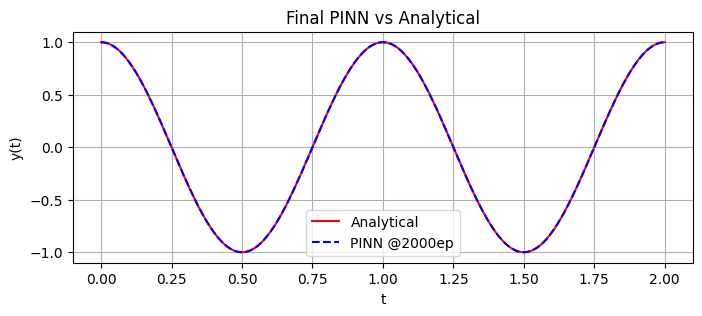

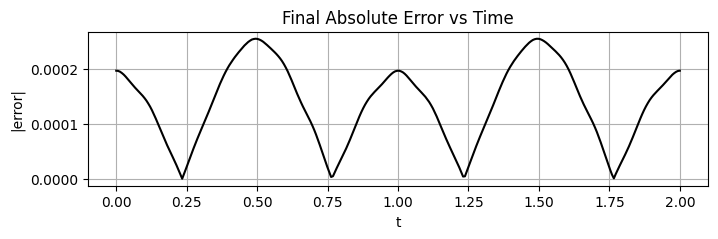

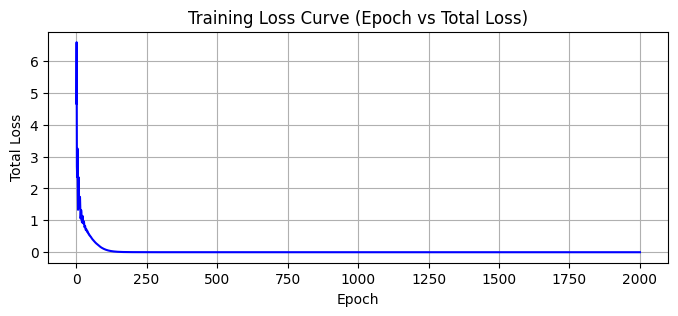

In [11]:
# === 1. IMPORTS & DEVICE SETUP ===

import torch                       # PyTorch library: for building and training neural networks
import torch.nn as nn              # PyTorch module for defining neural network layers and architectures
import torch.optim as optim        # PyTorch optimizers like Adam, SGD, etc.
import numpy as np                 # NumPy for efficient numerical arrays and math
import matplotlib.pyplot as plt    # For creating plots and visualizing results
import math                        # Python's standard math library (for constants like pi)
from matplotlib.animation import FuncAnimation  # For creating animations to show training progress visually
from IPython.display import HTML   # To display animations inside Jupyter notebooks

# Set device: If your computer has an Apple M1/M2 chip (Metal backend), use that. Otherwise, use CPU.
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# === 2. PROBLEM PARAMETERS & INITIAL CONDITIONS ===

omega = 2 * math.pi               # Angular frequency (omega = 2*pi for 1 second oscillation period)

y0 = torch.tensor([[1.0]], device=device)  # Initial displacement at time t=0 (y(0) = 1)
v0 = torch.tensor([[0.0]], device=device)  # Initial velocity at time t=0 (dy/dt = 0)

# === 3. COLLLOCATION POINTS (FOR PINN TRAINING ON THE ODE) ===

N_coll = 200                      # Number of randomly selected time points inside [0, 1] to enforce the ODE
t_coll = torch.rand(N_coll, 1, device=device)  # Random uniform time points between 0 and 1

# === 4. DEFINE THE PINN WITH FOURIER FEATURES (FOR PERIODIC INPUT REPRESENTATION) ===

class PINN_Feat(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        # Neural network structure: Input → 2 Fourier features → 2 hidden layers → 1 output (y)
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),  # First layer: input 2 features → hidden_dim neurons
            nn.Tanh(),                 # Nonlinear activation: Tanh helps capture nonlinearity
            nn.Linear(hidden_dim, hidden_dim),  # Second hidden layer
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)   # Output layer: 1 output → y(t)
        )

    def forward(self, t):
        t2pi = 2 * math.pi * t                                      # Scale t to 0→2pi range (Fourier domain)
        feat = torch.cat([torch.sin(t2pi), torch.cos(t2pi)], dim=1) # Create Fourier feature vector: [sin, cos]
        return self.net(feat)                                       # Feed features to network → predict y(t)

# Instantiate the model and move it to device (CPU or MPS)
model = PINN_Feat().to(device)

# === 5. DEFINE THE PHYSICS RESIDUAL (d²y/dt² + ω²y) ===

def pde_residual(t):
    t_req = t.clone().detach().requires_grad_(True)  # Allow gradients w.r.t time for autograd
    y = model(t_req)                                 # Network prediction: y(t)

    # First derivative dy/dt (velocity)
    dy = torch.autograd.grad(
        y, t_req, grad_outputs=torch.ones_like(y), create_graph=True
    )[0]

    # Second derivative d²y/dt² (acceleration)
    d2y = torch.autograd.grad(
        dy, t_req, grad_outputs=torch.ones_like(dy), create_graph=True
    )[0]

    # Return residual (error) from ODE: Should ideally be zero if ODE is satisfied
    return d2y + (omega**2)*y, y, dy

# === 6. TOTAL LOSS FUNCTION (PDE loss + Initial Condition loss) ===

def loss_fn(t_coll, t_ic, y_ic, v_ic):
    # ODE residual at collocation points
    residual, _, _ = pde_residual(t_coll)
    loss_pde = torch.mean(residual**2)  # Minimize mean squared error in residuals

    # Initial condition loss at t=0
    t0 = t_ic.clone().detach().requires_grad_(True)
    y0_pred = model(t0)  # Network's predicted y(0)
    dy0 = torch.autograd.grad(
        y0_pred, t0, grad_outputs=torch.ones_like(y0_pred),
        create_graph=True, allow_unused=True
    )[0]

    # If for some reason gradient is None, replace with zeros (safe fallback)
    if dy0 is None: dy0 = torch.zeros_like(y0_pred)

    # Total IC loss = error in y(0) + error in y'(0)
    loss_ic = torch.mean((y0_pred - y_ic)**2) + torch.mean((dy0 - v_ic)**2)

    return loss_pde + loss_ic  # Total loss

# === 7. OPTIMIZER & LEARNING RATE DECAY SCHEDULER ===

optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer for fast learning
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)  # Reduce LR every 500 epochs

# === 8. TRAINING LOOP ===

t_ic = torch.zeros((1,1), device=device)                 # t=0 for initial condition
t_test = torch.linspace(0, 2, 300, device=device).unsqueeze(1)  # Test grid: 300 points between 0 and 2

checkpoints = list(range(0, 1001, 10))  # Save predictions every 10 epochs (0-1000) for animation
preds = {}                              # Store checkpoint predictions
loss_history = []                       # Track loss over epochs

for ep in range(0, 2001):  # Train for 2000 epochs
    if ep > 0:
        optimizer.zero_grad()                               # Reset gradients
        L = loss_fn(t_coll, t_ic, y0, v0)                   # Compute total loss
        L.backward()                                        # Backpropagation: compute gradients
        optimizer.step()                                    # Update weights
        scheduler.step()                                    # Step the LR scheduler
        loss_history.append(L.item())                       # Save loss value for plotting

    if ep % 100 == 0:
        print(f"Epoch {ep:4d} | Loss: {loss_history[-1] if ep>0 else '----'}")

    if ep in checkpoints:
        with torch.no_grad():
            preds[ep] = model(t_test).cpu().numpy().flatten()  # Save predictions for animation

# Final prediction after training
with torch.no_grad():
    y_pred_final = model(t_test).cpu().numpy().flatten()

# === 9. ANALYTICAL SOLUTION FOR GROUND TRUTH COMPARISON ===

t_np = t_test.cpu().numpy().flatten()  # Convert tensor to NumPy array for plotting
y_true = y0.item()*np.cos(omega*t_np) + (v0.item()/omega)*np.sin(omega*t_np)  # True solution y(t)

# === 10. PLOT FINAL FIT: PINN vs ANALYTICAL ===

plt.figure(figsize=(8,3))
plt.plot(t_np, y_true, 'r-', label='Analytical')          # Ground truth curve
plt.plot(t_np, y_pred_final, 'b--', label='PINN @2000ep') # Final PINN prediction
plt.xlabel('t'); plt.ylabel('y(t)')
plt.title('Final PINN vs Analytical')
plt.legend(); plt.grid(True)
plt.show()

# === 11. PLOT FINAL ABSOLUTE ERROR | y_PINN - y_true | ===

err_final = np.abs(y_pred_final - y_true)
plt.figure(figsize=(8,2))
plt.plot(t_np, err_final, 'k-')
plt.xlabel('t'); plt.ylabel('|error|')
plt.title('Final Absolute Error vs Time')
plt.grid(True)
plt.show()

# === 12. PLOT EPOCH vs TOTAL LOSS (TRAINING LOSS CURVE) ===

plt.figure(figsize=(8,3))
plt.plot(np.arange(1, len(loss_history)+1), loss_history, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss Curve (Epoch vs Total Loss)')
plt.grid(True)
plt.show()

# === 13. ANIMATION: HOW PINN CONVERGED OVER EPOCHS ===

fig, ax = plt.subplots(figsize=(6,3))
ax.set_xlim(0,2); ax.set_ylim(-1.2,1.2)
ax.set_xlabel('t'); ax.set_ylabel('y(t)')
line_true, = ax.plot(t_np, y_true, 'r-', lw=2, label='Analytical')
line_pinn, = ax.plot([], [], 'b--', lw=2, label='PINN Prediction')
title = ax.text(0.5,1.05,'', transform=ax.transAxes, ha='center')
ax.legend()

frames = len(checkpoints)
interval = 10000 / frames  # Time per frame for a 10-second animation

def init():
    line_pinn.set_data([], [])
    title.set_text('')
    return line_pinn, title

def update(i):
    ep = checkpoints[i]
    line_pinn.set_data(t_np, preds[ep])           # Update PINN curve at this epoch
    title.set_text(f'Epoch = {ep}')
    return line_pinn, title

anim = FuncAnimation(fig, update, frames=frames, init_func=init,
                     blit=True, interval=interval)
plt.close(fig)
HTML(anim.to_jshtml())


# Results and Observations

## Final Fit vs Analytical Solution

The first plot shows the final prediction of the PINN (after 2000 epochs) compared against the exact analytical solution for the undamped harmonic oscillator ODE:

- The **blue dashed line** represents the **PINN-predicted solution** $y_{\theta}(t)$.
- The **red solid line** represents the **true analytical solution**:

$$
y_{\text{true}}(t) = y_0 \cos(\omega t) + \frac{v_0}{\omega} \sin(\omega t)
$$

where:

- $y_0 = 1.0$
- $v_0 = 0.0$
- $\omega = 2\pi$

The PINN closely tracks the true oscillatory behavior across the full time domain $t \in [0, 2]$.

---

## Absolute Error vs Time

The second plot shows the absolute error at each test time:

$$
\text{Error}(t) = \left| y_{\theta}(t) - y_{\text{true}}(t) \right|
$$

- The error remains below $3 \times 10^{-4}$ across the domain.
- Error oscillates in time following the shape of the sine/cosine but with very low amplitude, showing high prediction accuracy.

---

## Training Loss Curve (Epoch vs Total Loss)

The third plot shows how the total training loss $\mathcal{L}$ evolved over 2000 epochs.

- The loss decreased **monotonically and smoothly** over time.
- Indicates **stable convergence** with no divergence or oscillations.
- The total loss is:

$$
\mathcal{L} = \text{MSE}(\text{PDE residual}) + \text{MSE}(\text{IC error})
$$

---

## Animation of Training Progress

The fourth panel shows an **epoch-wise animation (from epoch 0 to 1000)** of how the PINN's output shape improved during training.

- The **blue dashed curve**: PINN at the current epoch.
- The **red solid curve**: Exact analytical solution.

You can observe how the PINN starts with a random prediction and gradually learns the correct sinusoidal form over training.

---

## Key Observations

- **Fourier Features Helped:**  
Using sine and cosine as input features significantly improved learning speed for this periodic ODE.

- **Small Network Was Sufficient:**  
Only two hidden layers with 64 neurons each were enough to achieve low error.

- **Smooth Loss Curve:**  
No major oscillations in loss; good convergence behavior.

- **Error Magnitude:**  
Final absolute error stayed below $3 \times 10^{-4}$, demonstrating high accuracy.

---

## Possible Future Work

- Test the model on non-periodic ODEs.
- Implement **soft energy conservation constraints** to enforce physical properties better.
- Try **L-BFGS optimizer** for potentially faster late-stage convergence.
- Train for larger $t$ domains (extrapolation ability).

---

## References

- Lu et al. (2024). *Solving Oscillator ODEs via Soft-Constrained PINN with Minimal Data*. arXiv:2408.11077
- DeepXDE Official Example Repository

**Atharva Joshi**  
IISER Bhopal, 2nd Year BSMS Student  
Pre-Major: Physics, Mathematics, and Data Science  
Submitted for: *Scientific Machine Learning* course, Project 1, IIT Mandi
